In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_17744\271246256.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')

In [3]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [7]:
x_train=[]
y_train=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        df['total_acceleration'] = df['accx']**2 + df['accy']**2 + df['accz']**2
        x_train.append(df.values[:500])
        y_train.append(activity)

In [8]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}") 
print(f'Shape of y_train = {y_train.shape}')

Shape of X_train = (126, 500, 4)
Shape of y_train = (126,)


## Question 1

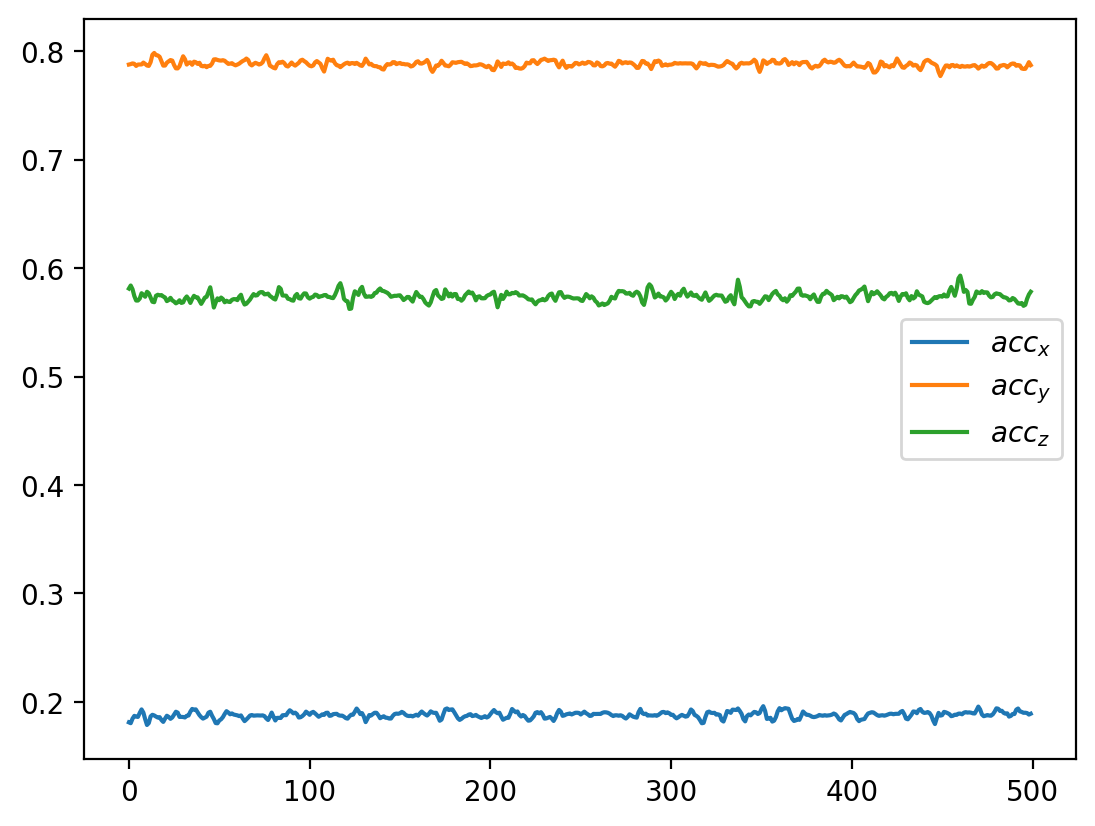

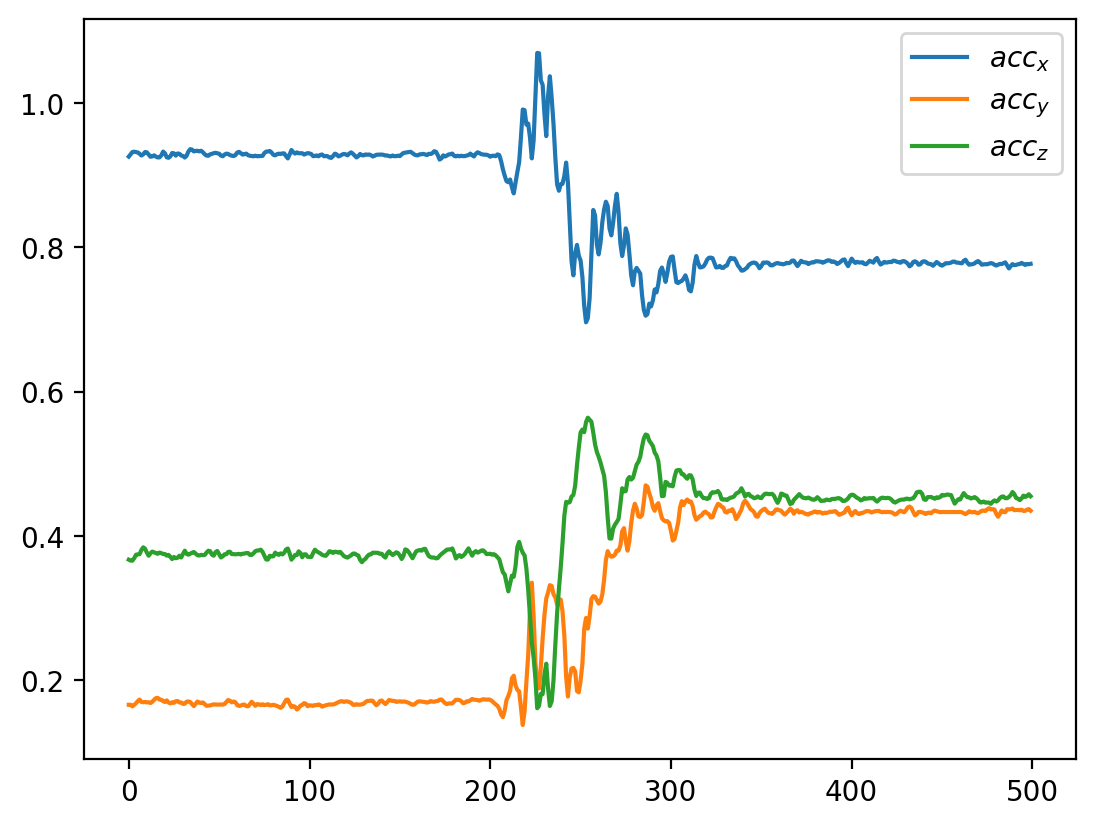

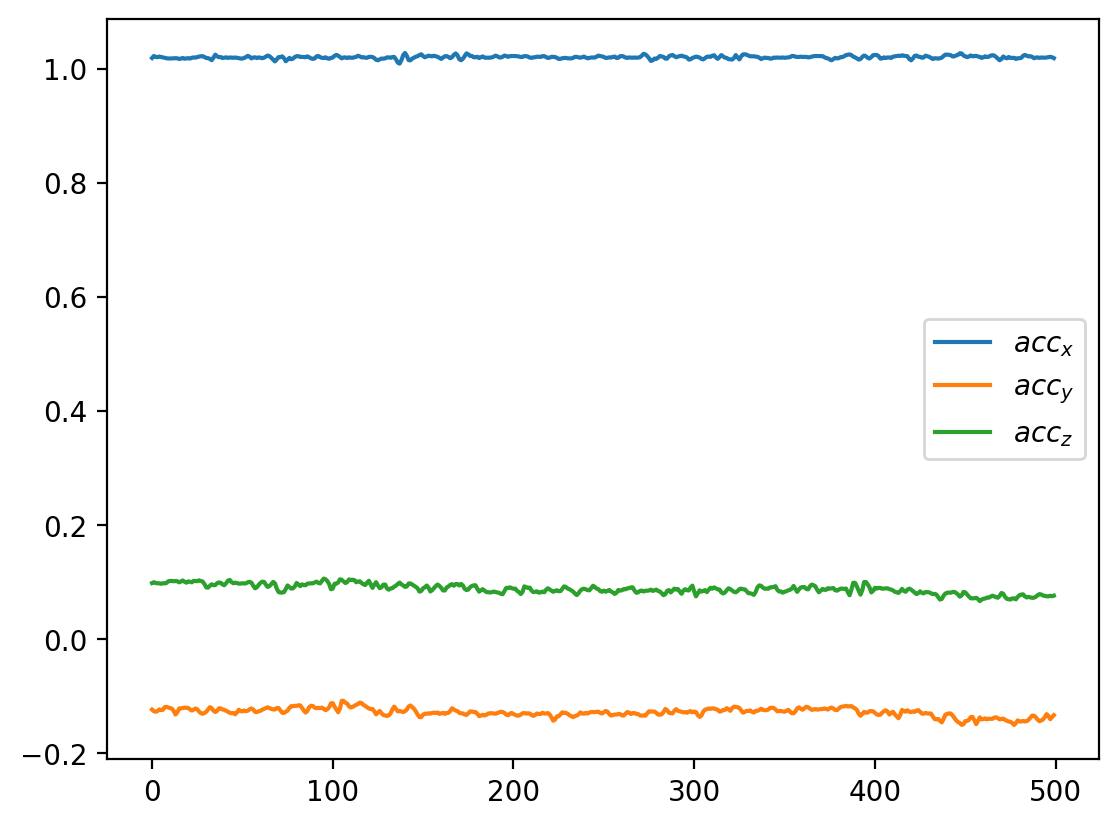

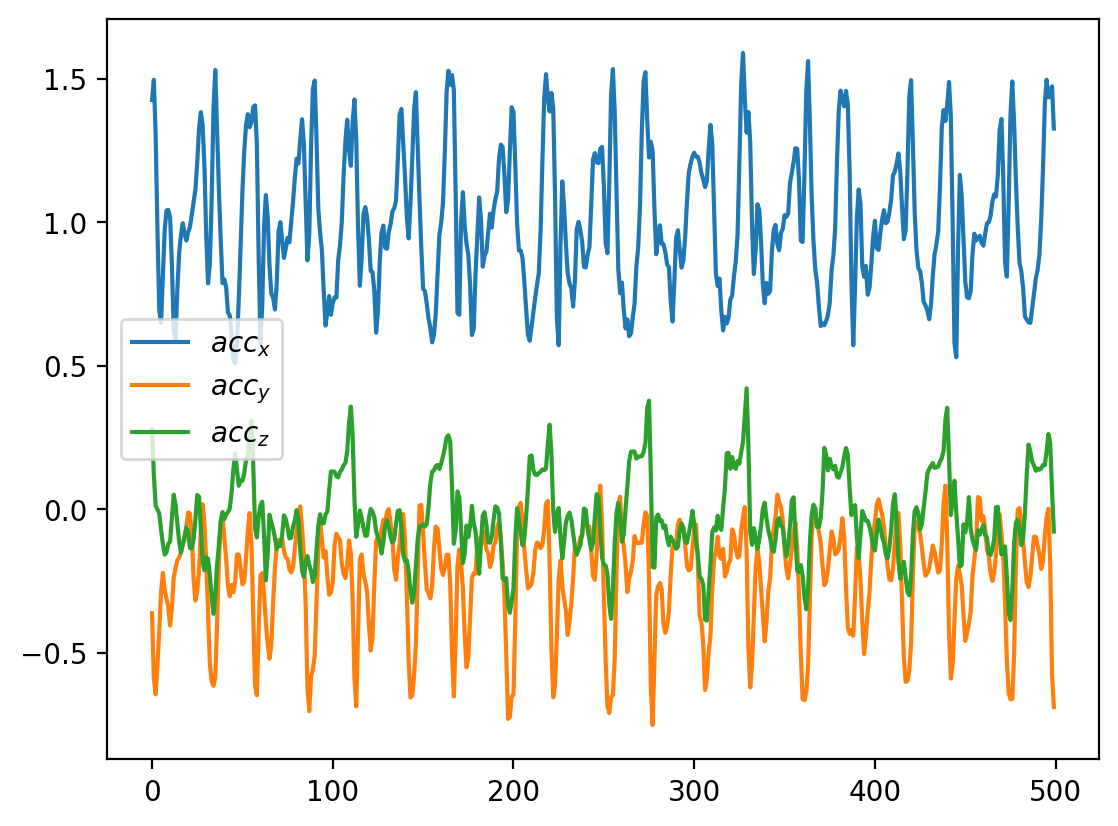

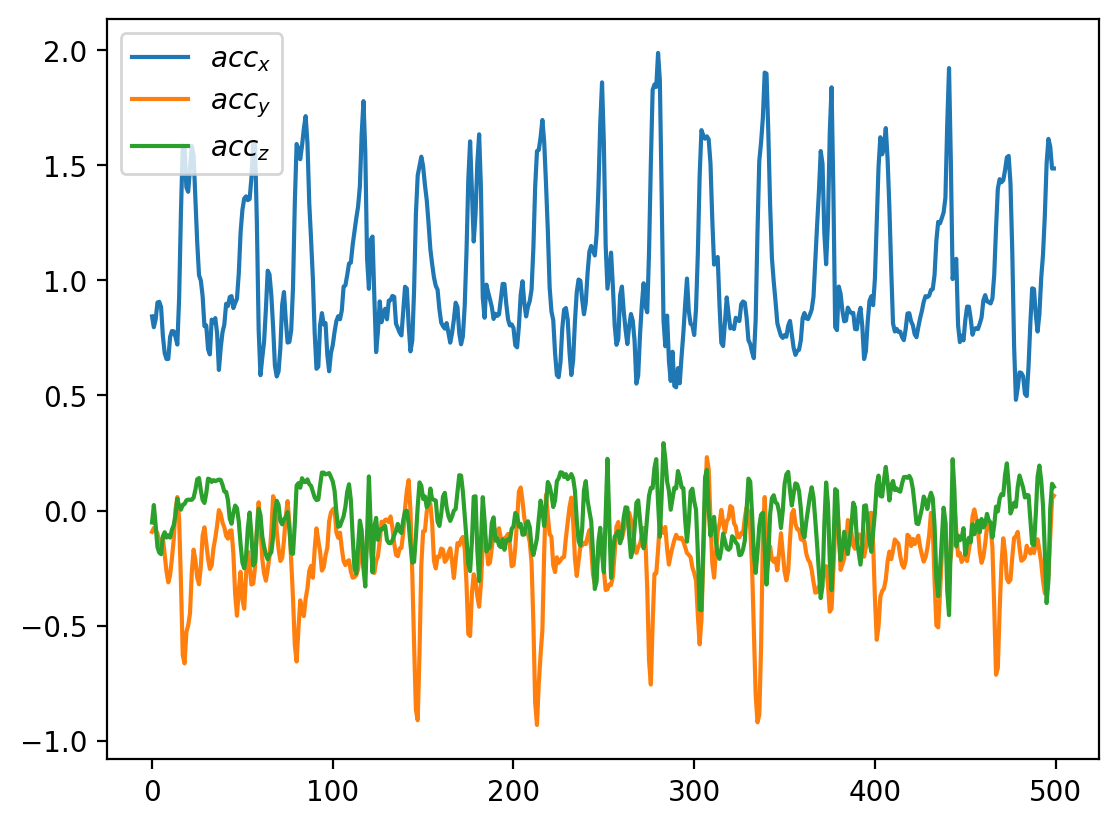

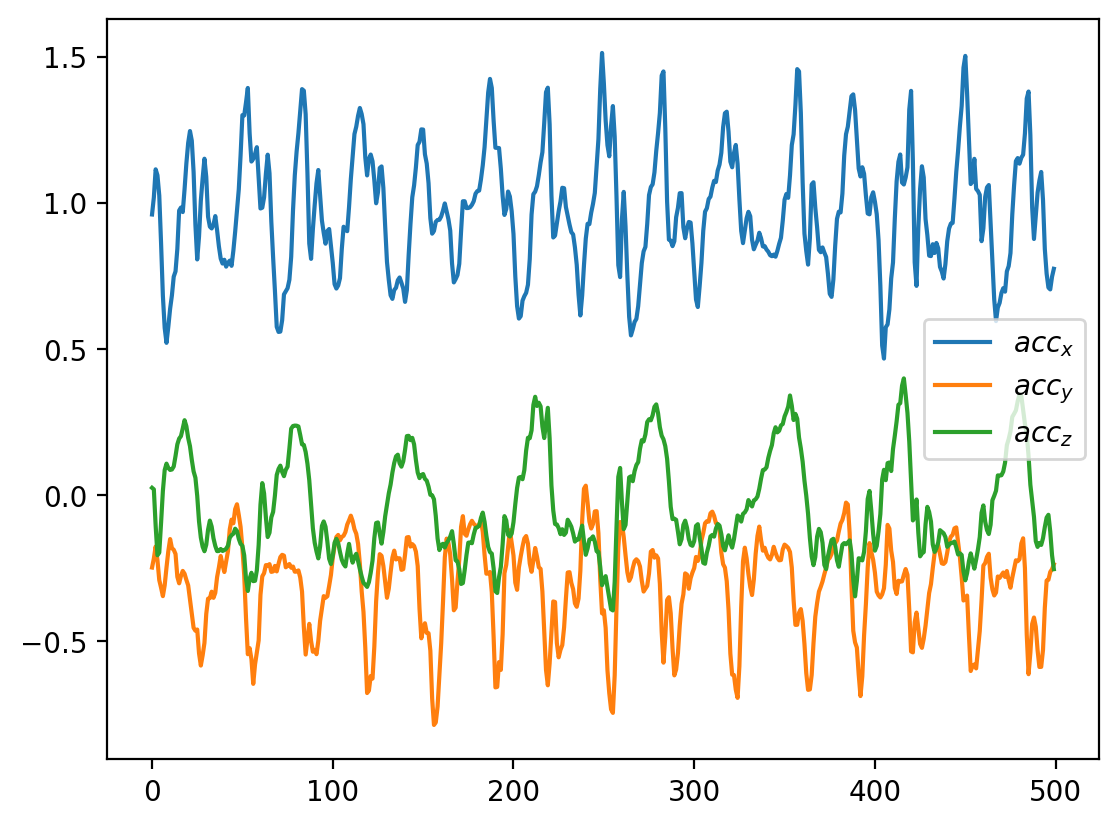

In [9]:
# plt.figure(figsize = (40,40))
for i in range(6):
    activity = activities[i]
    data = x_train[i*21]
    acc_x = data[:,0]
    acc_y = data[:,1]
    acc_z = data[:,2]
    x = np.arange(0,500,1)
    # plt.subplot(3,6,i+1)
    plt.plot(x,acc_x,label='$acc_x$')
    # plt.subplot(3,6,i+7)
    plt.plot(x,acc_y,label='$acc_y$')
    # plt.subplot(3,6,i+13)
    plt.plot(x,acc_z,label='$acc_z$')
    plt.legend()
    plt.show()
plt.show()

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

In [12]:
dt

DecisionTreeClassifier(random_state=42)

(126, 4)